<a href="https://colab.research.google.com/github/kireeti-kunam/Application-of-Bootstrap-samples-in-Random-Forest/blob/main/Clustering_on_graph_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='red'><center>Clustering On graph dataset</center></font>

In [2]:

# Importing Libraries:

import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [ ]:
# to install this you need to use "pip install stellargraph"

In [5]:
data=pd.read_csv('/content/movie_actor_network.csv', index_col=False, names=['movie','actor'])
data.head(5)

,movie,actor
0,m1,a1
1,m2,a1
2,m2,a2
3,m3,a1
4,m3,a3


In [6]:
data.shape

(9650, 2)

##### Here our data set is in the form bipartite grpah format.
 - what is bipartite graph?
  - In the mathematical field of graph theory, a bipartite graph (or bigraph) is a graph whose vertices can be divided into two disjoint and independent sets and such that every edge connects a vertex in to one in.

In [7]:
# Taking all edges in dataset as a tuple
edges = [tuple(x) for x in data.values.tolist()]

In [8]:
# creating graph with networkx library:

B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')  # creating first bipartite set with all movie nodes.
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')  # creating first bipartite set with all actor nodes.
B.add_edges_from(edges, label='acted')

In [9]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

A = list(connected_component_subgraphs(B))[0]  # taking all connected components in the grpah

In [ ]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


In [ ]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


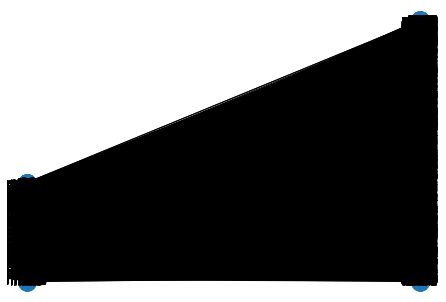

In [ ]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [ ]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )  

# Here we created matrix of size 4703*100. Every row is represents one node, it can be either movie or actor. ex: if row id is m2-> then we will start wark from m2 untill max length 100.

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [ ]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [ ]:
# Retrieve node embeddings and corresponding subjects

node_ids = model.wv.index2word  # list of node IDs or keys (here keys means our nodes ex:m1,a1,m6,a9,...)

node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality or (taking value or vector representation for each key or node)

node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids] 

In [ ]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

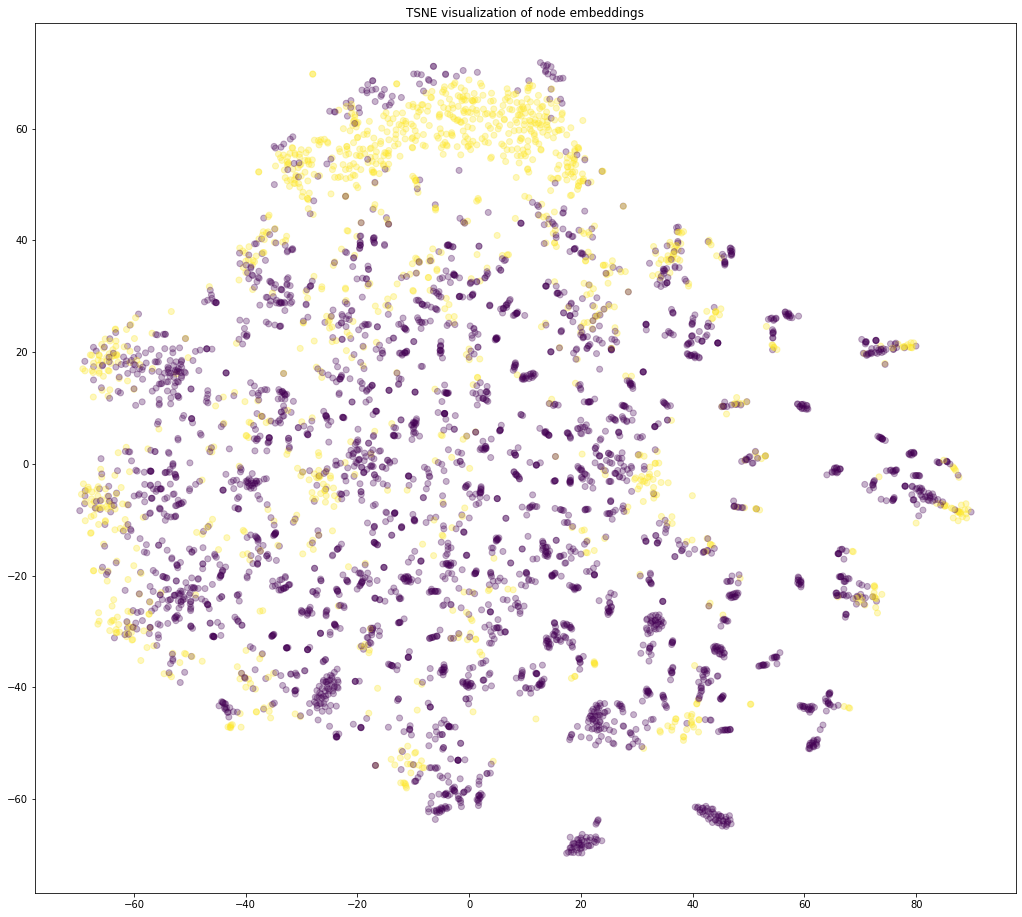

In [ ]:
import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

<br>

<br>

<br>

# <font color='red'>Clustering</font>

- data_split:
 - In this function we are taking all actor nodes,movie nodes, actor embeddings, movie embeddings.

In [ ]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes

    for index,id in enumerate(node_ids):
      if node_targets[index]=='actor':
        actor_nodes.append(id)
        actor_embeddings.append(node_embeddings[index])
      elif node_targets[index]=='movie':
        movie_nodes.append(id)
        movie_embeddings.append(node_embeddings[index])
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [ ]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<font color='blue'>Grouping similar actors</font>

In [ ]:
cluster_parameters = [3,10,15,18,30]

for param in cluster_parameters:
      kmeans = KMeans(n_clusters = param, random_state=0).fit(np.array(actor_embeddings))
      labels = kmeans.labels_
      cost_1=0
      cost_2=0
      for each_sub_cluster in range(param):
        ego_edges = []
        movies_in_cluster = set()
        actors_in_cluster = set()
        for index,label in enumerate(labels):
          if label==each_sub_cluster:
            ego_edges.append(nx.ego_graph(B,actor_nodes[index]).edges)
        all_edges = [tuple(j) for i in range(len(ego_edges)) for j in ego_edges[i]]

        for i,j in all_edges:
          if 'm' in i:
            movies_in_cluster.add(i)
            actors_in_cluster.add(j)
          else:
            actors_in_cluster.add(i)
            actors_in_cluster.add(j)
        
        
        sub_cluster_graph= nx.Graph()
        sub_cluster_graph.add_nodes_from(actors_in_cluster, bipartite=0) # Add the node attribute "bipartite"
        sub_cluster_graph.add_nodes_from(movies_in_cluster, bipartite=1)
        sub_cluster_graph.add_edges_from(all_edges)

        conn_components = [sub_cluster_graph.subgraph(c) for c in nx.connected_components(sub_cluster_graph)]
        cost_1+=((len(max(conn_components,key=len).nodes))/len(sub_cluster_graph.nodes))
        cost_2+=sub_cluster_graph.number_of_edges()/(len(movies_in_cluster))
      

      cost_1/=param
      cost_2/=param

      print("For the value of k={0} the cost_1 is: {1} and cost_2 is: {2} and total cost is:{3}".format(param,cost_1,cost_2,cost_1*cost_2))


For the value of k=3 the cost_1 is: 0.9081196061822031 and cost_2 is: 5.561718036146803 and total cost is:5.0507051926820905
For the value of k=10 the cost_1 is: 0.8915201650295282 and cost_2 is: 3.925073838243512 and total cost is:3.49928247602394
For the value of k=15 the cost_1 is: 0.9219817486680764 and cost_2 is: 3.8148585905670003 and total cost is:3.517229994252396
For the value of k=18 the cost_1 is: 0.8751873969117441 and cost_2 is: 3.7056531105722703 and total cost is:3.2431408996996525
For the value of k=30 the cost_1 is: 0.8439420318740184 and cost_2 is: 3.4889962827256267 and total cost is:2.9445106120443625


#### for k=3 .,we are getting good scores so we will form 3 clusters for actors.

<font color='blue'>Displaying similar actor clusters</font>

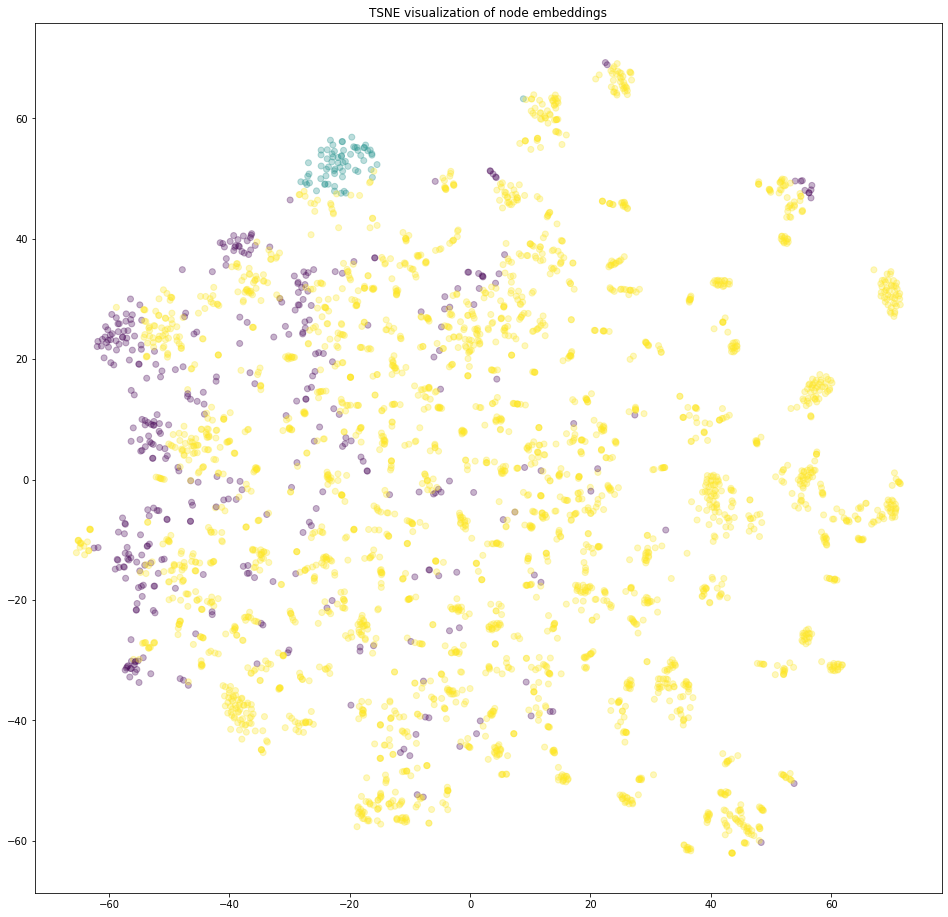

In [ ]:
kmeans = KMeans(n_clusters = 3, random_state=0).fit(np.array(actor_embeddings))
labels = kmeans.labels_


from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(actor_embeddings)


# draw the points

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=labels, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

<br>

<font color='blue'>Grouping similar movies</font>

In [ ]:
cluster_parameters = [3,10,15,18,30]

for param in cluster_parameters:
      kmeans = KMeans(n_clusters = param, random_state=0).fit(np.array(movie_embeddings))
      labels = kmeans.labels_
      cost_1=0
      cost_2=0
      for each_sub_cluster in range(param):
        ego_edges = []
        movies_in_cluster = set()
        actors_in_cluster = set()
        for index,label in enumerate(labels):
          if label==each_sub_cluster:
            ego_edges.append(nx.ego_graph(B,movie_nodes[index]).edges)
        all_edges = [tuple(j) for i in range(len(ego_edges)) for j in ego_edges[i]]

        for i,j in all_edges:
          if 'm' in i:
            movies_in_cluster.add(i)
            actors_in_cluster.add(j)
          else:
            actors_in_cluster.add(i)
            actors_in_cluster.add(j)
        
        
        sub_cluster_graph= nx.Graph()
        sub_cluster_graph.add_nodes_from(movies_in_cluster, bipartite=0) # Add the node attribute "bipartite"
        sub_cluster_graph.add_nodes_from(actors_in_cluster, bipartite=1)
        sub_cluster_graph.add_edges_from(all_edges)

        conn_components = [sub_cluster_graph.subgraph(c) for c in nx.connected_components(sub_cluster_graph)]
        cost_1+=((len(max(conn_components,key=len).nodes))/len(sub_cluster_graph.nodes))
        cost_2+=sub_cluster_graph.number_of_edges()/(len(actors_in_cluster))
      

      cost_1/=param
      cost_2/=param

      print("For the value of k={0} the cost_1 is: {1} and cost_2 is: {2} and total cost is:{3}".format(param,cost_1,cost_2,cost_1*cost_2))


For the value of k=3 the cost_1 is: 0.9831697999778144 and cost_2 is: 1.991370286608376 and total cost is:1.95785512636652
For the value of k=10 the cost_1 is: 0.933681115462974 and cost_2 is: 1.8159662021863248 and total cost is:1.6955333493003883
For the value of k=15 the cost_1 is: 0.9637408821805985 and cost_2 is: 1.64906539869254 and total cost is:1.5892717421094489
For the value of k=18 the cost_1 is: 0.9500736449668542 and cost_2 is: 1.7205768552594622 and total cost is:1.6346747243219648
For the value of k=30 the cost_1 is: 0.9574588028839734 and cost_2 is: 1.5240714404867068 and total cost is:1.4592356169180554


#### for k=3 .,we are getting good scores so we will form 3 clusters for movies.

<font color='blue'>Displaying similar movie clusters</font>

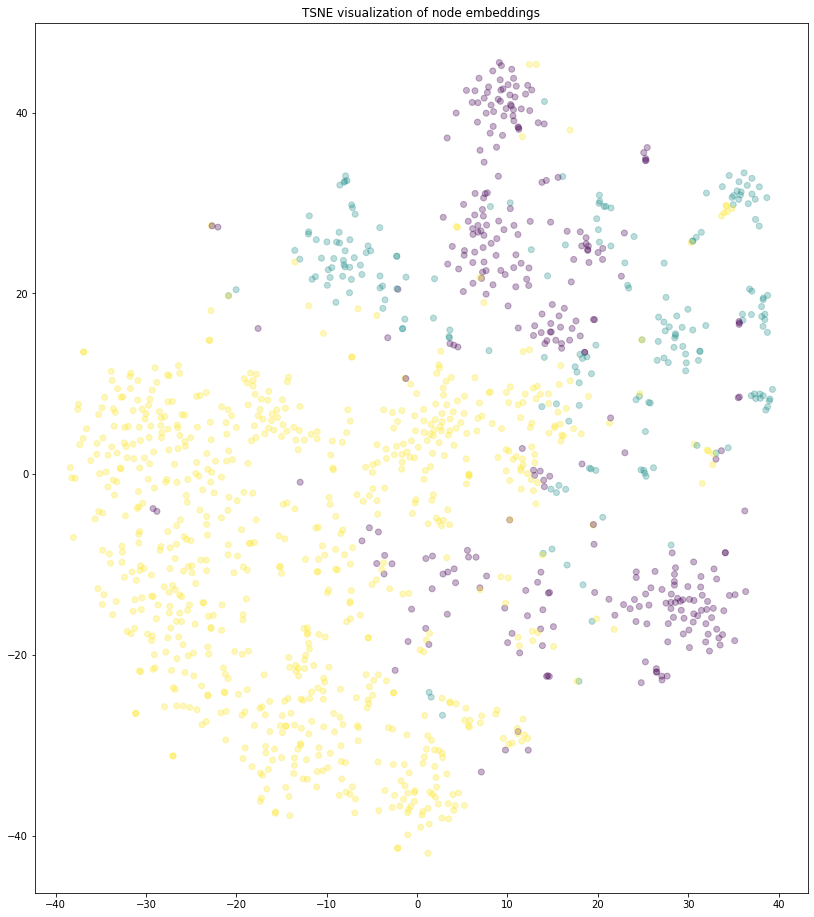

In [ ]:
kmeans = KMeans(n_clusters = 3, random_state=0).fit(np.array(movie_embeddings))
labels = kmeans.labels_


from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(movie_embeddings)


# draw the points

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=labels, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()